In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import ElementNotInteractableException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.select import Select
import time
from tqdm.notebook import tqdm
from glob import glob
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import json
import folium
import warnings
import numpy as np
import datetime
import re


In [ ]:
url = "https://www.imdb.com/"
driver = webdriver.Chrome(service=Service("../driver/chromedriver"))
driver.get(url)

In [ ]:
search = driver.find_element(By. ID, "suggestion-search")
search.click()
search.send_keys('The Big Bang Theory')

In [ ]:
select_title = driver.find_element(By.ID, "react-autowhatever-navSuggestionSearch--item-0")
select_title.click()

### 회차 조회

In [ ]:
select_title = driver.find_element(By.CLASS_NAME, 'episode-guide-text')
select_title.click()

In [ ]:
episode_elements = driver.find_elements(By.CLASS_NAME, 'ipc-title__text')
episode_titles = [episode.text for episode in episode_elements]
episode_titles

In [ ]:
try:
    # "season" 탭 요소 찾기 (클래스를 사용하여)
    season_tab = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, 'ipc-tab-link'))
    )

    # "season" 탭 클릭
    season_tab.click()

    # 임시 리스트 생성
    data = []

    # "season" 탭이 클릭된 후에 각 시즌으로 이동하여 에피소드 제목 가져오기
    for season_number in range(1, 13):  # 1부터 12까지의 시즌
        # 시즌 페이지 URL 생성
        season_url = f'https://www.imdb.com/title/tt0898266/episodes/?season={season_number}'

        # 시즌 페이지로 이동
        driver.get(season_url)

        # 해당 페이지의 모든 요소가 로드될 때까지 대기
        time.sleep(1)

        # 해당 시즌의 모든 에피소드 제목 요소 찾기
        episode_elements = driver.find_elements(By.CLASS_NAME, 'ipc-title__text')
        season_episode_titles = [episode.text for episode in episode_elements if episode.text.startswith('S')]

        # 데이터 리스트에 추가
        for episode_title in season_episode_titles:
            data.append({'Season': f'Season {season_number}', 'Title': episode_title})

    # 데이터 프레임 생성
    df = pd.DataFrame(data)

except Exception as e:
    print("An error occurred:", e)

# 데이터 프레임 출력
print(df)

In [ ]:
df.to_excel('../data/episode_data.xlsx', index=False)

### 상영일자 조회

In [ ]:
# 임시 리스트 생성
episode_aired_dates = []

# "season" 탭이 클릭된 후에 각 시즌으로 이동하여 에피소드 제목과 방영일 가져오기
for season_number in range(1, 13):  # 1부터 12까지의 시즌
    # 시즌 페이지 URL 생성
    season_url = f'https://www.imdb.com/title/tt0898266/episodes/?season={season_number}'

    # 시즌 페이지로 이동
    driver.get(season_url)

    # 해당 페이지의 모든 요소가 로드될 때까지 대기
    time.sleep(1)

    # 해당 시즌의 모든 에피소드 방영일 요소 찾기
    episode_aired_elements = driver.find_elements(By.CLASS_NAME, 'sc-f2169d65-10.iZXnmI')
    
    # 에피소드 방영일 가져와서 리스트에 추가
    for element in episode_aired_elements:
        episode_aired_dates.append(element.text)

# 'Episode aired' 컬럼을 데이터프레임에 추가
df['Aired'] = episode_aired_dates

# 데이터프레임 출력
print(df)


### 방영일 형식 수정

In [ ]:
# Episode aired 컬럼의 값을 수정하여 YYYY.MM.DD 형식으로 변경
df['Aired'] = df['Aired'].apply(lambda x: datetime.datetime.strptime(x, "%a, %b %d, %Y").strftime("%Y.%m.%d"))

# 데이터프레임 출력
print(df)

In [ ]:
df.to_excel('../data/episode_aired_update.xlsx', index=False)

### 평점 조회

In [ ]:
# IMDb rating 요소를 클래스를 사용하여 찾기
rating_element = driver.find_element(By.CSS_SELECTOR, ".ipc-rating-star--base")

# 요소 내부의 텍스트 가져오기
rating_text = rating_element.text

# 가져온 텍스트 출력
print(rating_text)

### 평점 조회시 Seasons 탭의 정보만 알고 싶음.
### 하지만 그 위에 TOP-RATED에 속하는 에피소드 평점도 가져옴;;

### 그래서 Seasons 탭에 해당하는 클래스 찾은 후 평점 가져오기!

In [ ]:
# 클래스를 사용하여 상위 요소를 찾기
parent_element = driver.find_element(By.CSS_SELECTOR, ".sc-f2169d65-1")

# 상위 요소 내부의 평점 요소를 클래스를 사용하여 찾기
rating_element = parent_element.find_element(By.CSS_SELECTOR, ".ipc-rating-star--base")

# 평점 요소의 텍스트 가져오기
rating_text = rating_element.text

# 가져온 텍스트에서 숫자만 추출하여 실수로 변환
rating_value = re.search(r'(\d+\.\d+)', rating_text).group(0)
rating_float = float(rating_value)

# 가져온 평점 값 출력
print(rating_float)

In [ ]:
# 임시 리스트 생성
ratings = []

# "season" 탭이 클릭된 후에 각 시즌으로 이동하여 에피소드 평점 가져오기
for season_number in range(1, 13):  # 1부터 12까지의 시즌
    # 시즌 페이지 URL 생성
    season_url = f'https://www.imdb.com/title/tt0898266/episodes/?season={season_number}'

    # 시즌 페이지로 이동
    driver.get(season_url)

    # 해당 페이지의 모든 요소가 로드될 때까지 대기
    time.sleep(1)

    # 해당 시즌의 모든 에피소드 평점 요소 찾기
    rating_elements = driver.find_elements(By.CLASS_NAME, 'sc-f2169d65-1.bomFtL')
    
    # 에피소드 평점 가져와서 리스트에 추가
    for element in rating_elements:
        # 에피소드 평점에서 숫자만 추출하여 실수로 변환
        rating_text = element.text
        rating_value = re.search(r'(\d+\.\d+)', rating_text)
        
        # 평점이 있는 경우에만 추가
        if rating_value:
            rating_float = float(rating_value.group(0))
            ratings.append(rating_float)

# 'Rated' 컬럼을 데이터프레임에 추가
df['Rated'] = ratings

# 데이터프레임 출력
print(df)


In [ ]:
df.to_excel('../data/episode_rated_update.xlsx', index=False)

### 크롤링 완료 -> 창 off

In [ ]:
driver.close()

### 데이터 분석

### 저장한 파일 불러오기

In [3]:
df = pd.read_excel('../data/episode_rated_update.xlsx')
df

,Season,Title,Aired,Rated
0,Season 1,S1.E1 ∙ Pilot,2007.09.24,8.1
1,Season 1,S1.E2 ∙ The Big Bran Hypothesis,2007.10.01,8.2
2,Season 1,S1.E3 ∙ The Fuzzy Boots Corollary,2007.10.08,7.6
3,Season 1,S1.E4 ∙ The Luminous Fish Effect,2007.10.15,8.0
4,Season 1,S1.E5 ∙ The Hamburger Postulate,2007.10.22,7.9
...,...,...,...,...
274,Season 12,S12.E20 ∙ The Decision Reverberation,2019.04.25,7.1
275,Season 12,S12.E21 ∙ The Plagiarism Schism,2019.05.02,7.2
276,Season 12,S12.E22 ∙ The Maternal Conclusion,2019.05.09,7.9
277,Season 12,S12.E23 ∙ The Change Constant,2019.05.16,9.0


In [4]:
# Episode Title 컬럼에서 Season 정보 추출
df['Season'] = df['Title'].str.extract('([^∙]+)')

# Episode Title 컬럼에서 Season 정보 이전의 텍스트 추출하여 Season 컬럼으로 채우기
df['Title'] = df['Title'].str.split('∙').str[1]

# 데이터 프레임 출력
df

,Season,Title,Aired,Rated
0,S1.E1,Pilot,2007.09.24,8.1
1,S1.E2,The Big Bran Hypothesis,2007.10.01,8.2
2,S1.E3,The Fuzzy Boots Corollary,2007.10.08,7.6
3,S1.E4,The Luminous Fish Effect,2007.10.15,8.0
4,S1.E5,The Hamburger Postulate,2007.10.22,7.9
...,...,...,...,...
274,S12.E20,The Decision Reverberation,2019.04.25,7.1
275,S12.E21,The Plagiarism Schism,2019.05.02,7.2
276,S12.E22,The Maternal Conclusion,2019.05.09,7.9
277,S12.E23,The Change Constant,2019.05.16,9.0


In [6]:
df.to_excel('../data/episode_final_update.xlsx', index=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Season  279 non-null    object 
 1   Title   279 non-null    object 
 2   Aired   279 non-null    object 
 3   Rated   279 non-null    float64
dtypes: float64(1), object(3)
memory usage: 8.8+ KB


### 평점순 에피소드 정렬

In [ ]:
df_sorted_by_rated = df.sort_values(by='Rated', ascending=False).reset_index(drop=True)

df_sorted_by_rated

### 방영일 오래된 순 정렬

In [ ]:
df_sorted_by_date = df.sort_values(by='Aired', ascending=True).reset_index(drop=True)

df_sorted_by_date

### 최근 방영일 순 정렬

In [ ]:
df_sorted_by_date = df.sort_values(by='Aired', ascending=False).reset_index(drop=True)

df_sorted_by_date

### 각 시즌별 평점 분포

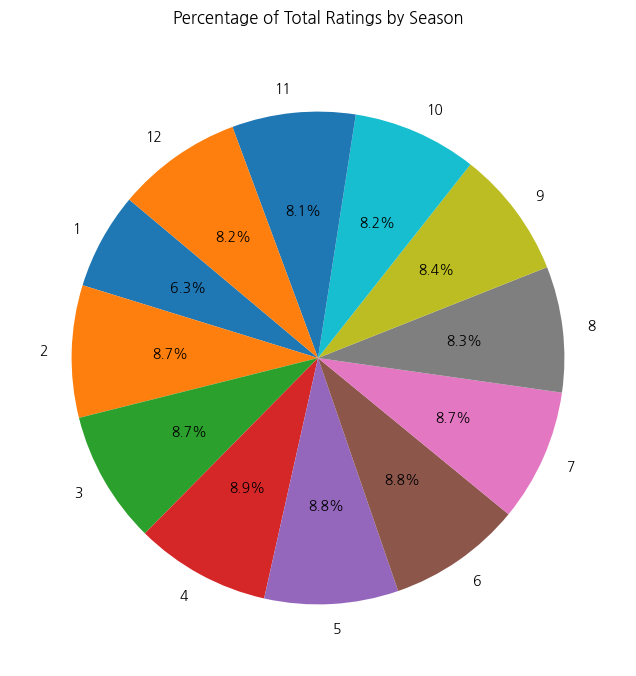

In [32]:
# Excel 파일에서 데이터 프레임으로 불러오기
df = pd.read_excel('../data/episode_final_update.xlsx')

# 시즌 번호 추출 함수 정의
def extract_season_number(season):
    return int(season.split('.')[0].replace('S', ''))

# 'Season' 열에서 시즌 번호 추출
df['SeasonNumber'] = df['Season'].apply(extract_season_number)

# 각 시즌별 총 평점 계산
season_total_ratings = df.groupby('SeasonNumber')['Rated'].sum()

# 전체 총 평점 계산
total_ratings = df['Rated'].sum()

# 각 시즌별 총 평점이 전체 총 평점 중에서 차지하는 백분율 계산
season_ratings_percentage = (season_total_ratings / total_ratings) * 100

# 원 그래프 생성
plt.figure(figsize=(8, 8))
plt.pie(season_ratings_percentage, labels=season_ratings_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Ratings by Season', pad=20)  # 제목에 공백 추가
plt.gca().set_aspect('equal')  # 원이 동그랗게 보이도록 함
plt.show()

### 재밌는 시즌 줄세우기

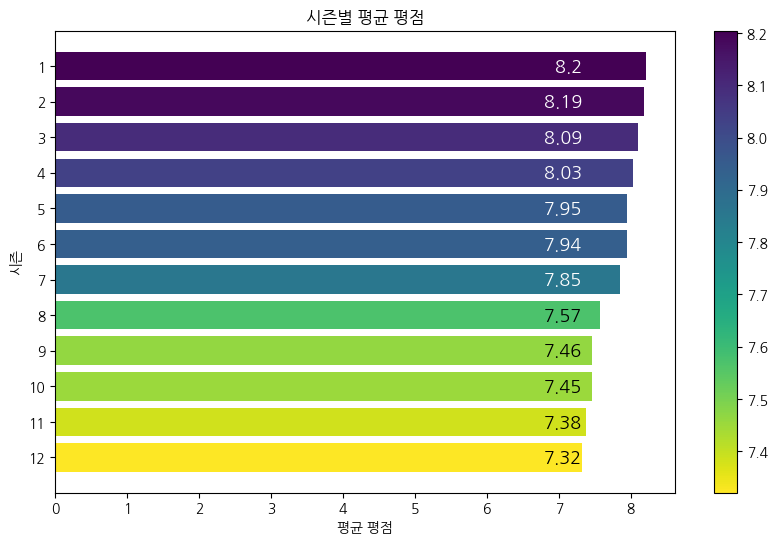

In [25]:
# Excel 파일에서 데이터 프레임으로 불러오기
df = pd.read_excel('../data/episode_final_update.xlsx')

# 시즌 번호 추출 함수 정의
def extract_season_number(season):
    return int(season.split('.')[0].replace('S', ''))

# 'Season' 열에서 시즌 번호 추출하여 새로운 열 생성
df['SeasonNumber'] = df['Season'].apply(extract_season_number)

# 같은 시즌별 평균 평점 계산
season_avg_ratings = df.groupby('SeasonNumber')['Rated'].mean()
# 내림차순 정렬 후 인덱스 재설정
season_avg_ratings = season_avg_ratings.sort_values(ascending=False).reset_index(drop=True)

# 히트맵 색상 설정
norm = plt.Normalize(season_avg_ratings.min(), season_avg_ratings.max())
colors = plt.cm.viridis_r(norm(season_avg_ratings))

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(season_avg_ratings)), season_avg_ratings, color=colors)

# 막대 그래프의 y축 위치 조정
plt.gca().invert_yaxis()

# 막대 그래프 위에 평균 평점 표시
for i, rating in enumerate(season_avg_ratings):
    text_color = 'black' if (rating - season_avg_ratings.min()) / (season_avg_ratings.max() - season_avg_ratings.min()) < 0.5 else 'white'
    plt.text(season_avg_ratings.min(), i, round(rating, 2), ha='right', va='center', color=text_color, fontsize=13)

# 히트맵 설정
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])
plt.colorbar(sm, orientation='vertical', ax=plt.gca())  # Specify Axes for colorbar

plt.title('시즌별 평균 평점')
plt.xlabel('평균 평점')
plt.ylabel('시즌')
plt.yticks(np.arange(len(season_avg_ratings)), season_avg_ratings.index + 1)
plt.show()